In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


In [2]:
# Generate data paths with labels
data_dir = "D:/CXR8/ChestX-ray"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
df

,filepaths,labels
0,D:/CXR8/ChestX-ray\Atelectasis\00000011_006.png,Atelectasis
1,D:/CXR8/ChestX-ray\Atelectasis\00000030_000.png,Atelectasis
2,D:/CXR8/ChestX-ray\Atelectasis\00000030_001.png,Atelectasis
3,D:/CXR8/ChestX-ray\Atelectasis\00000032_054.png,Atelectasis
4,D:/CXR8/ChestX-ray\Atelectasis\00000047_003.png,Atelectasis
...,...,...
10495,D:/CXR8/ChestX-ray\Pneumothorax\00029437_001.png,Pneumothorax
10496,D:/CXR8/ChestX-ray\Pneumothorax\00029437_002.png,Pneumothorax
10497,D:/CXR8/ChestX-ray\Pneumothorax\00029437_004.png,Pneumothorax
10498,D:/CXR8/ChestX-ray\Pneumothorax\00029437_005.png,Pneumothorax


In [4]:
# Split dataframe into train, validation, and test sets
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)


In [5]:
# Image properties
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended: use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# This function will be used in image data generator for data augmentation, it just takes the image and returns it again.
def scalar(img):
    return img

# Data augmentation
tr_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# Note: we will use custom test_batch_size, and make shuffle=False
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 8400 validated image filenames belonging to 15 classes.
Found 1260 validated image filenames belonging to 15 classes.
Found 840 validated image filenames belonging to 15 classes.


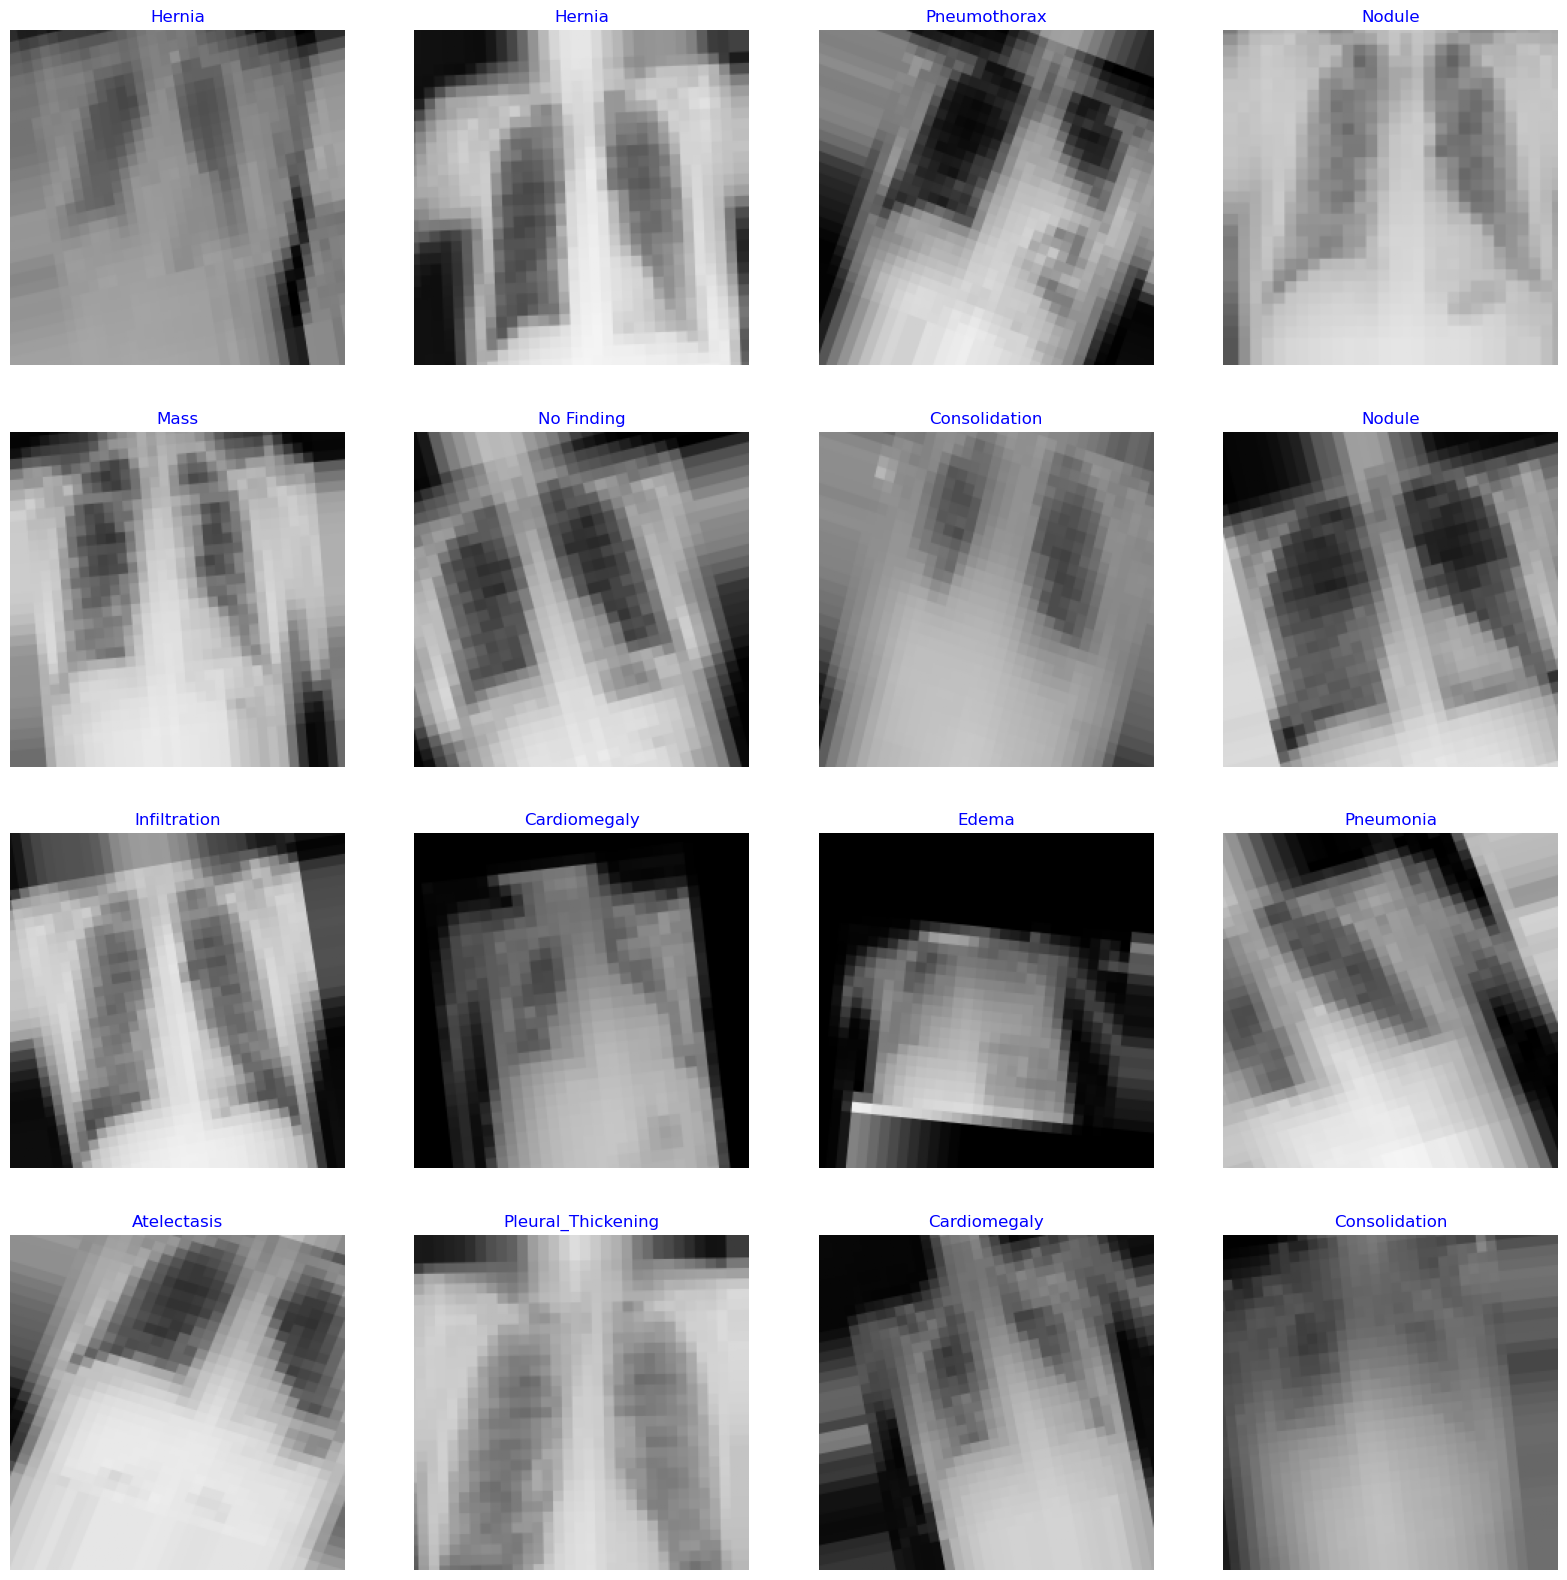

In [6]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), class names: string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


In [7]:
# Create Model Structure
img_size = (64, 64)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define number of classes in dense layer

# Create pre-trained model (you can build on pretrained model such as: EfficientNet, VGG, Resnet)
# We will use EfficientNetB0 from EfficientNet family.
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='avg'
)

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

16705208/16705208 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 4,386,482
Trainable params: 4,341,899
Non-t

In [11]:

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_gen, epochs=90, validation_data=valid_gen, callbacks=[reduce_lr, early_stopping], shuffle=False)


Epoch 1/90
525/525 [==============================] - 88s 167ms/step - loss: 2.1588 - accuracy: 0.3388 - val_loss: 2.2246 - val_accuracy: 0.3198 - lr: 2.0000e-04
Epoch 2/90
525/525 [==============================] - 84s 160ms/step - loss: 2.1164 - accuracy: 0.3630 - val_loss: 2.1999 - val_accuracy: 0.3190 - lr: 2.0000e-04
Epoch 3/90
525/525 [==============================] - 85s 161ms/step - loss: 2.0842 - accuracy: 0.3713 - val_loss: 2.1989 - val_accuracy: 0.3405 - lr: 2.0000e-04
Epoch 4/90
525/525 [==============================] - 88s 168ms/step - loss: 2.0561 - accuracy: 0.3843 - val_loss: 2.2130 - val_accuracy: 0.3452 - lr: 2.0000e-04
Epoch 5/90
525/525 [==============================] - 85s 161ms/step - loss: 2.0199 - accuracy: 0.3962 - val_loss: 2.1836 - val_accuracy: 0.3437 - lr: 2.0000e-04
Epoch 6/90
525/525 [==============================] - 85s 162ms/step - loss: 1.9836 - accuracy: 0.4102 - val_loss: 2.2812 - val_accuracy: 0.3357 - lr: 2.0000e-04
Epoch 7/90
525/525 [========

In [12]:
# Evaluate the model
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Plot training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

12/12 [==============================] - 1s 116ms/step - loss: 2.1481 - accuracy: 0.3750
Train Loss:  1.542409896850586
Train Accuracy:  0.5729166865348816
--------------------
Validation Loss:  2.249927282333374
Validation Accuracy:  0.2760416567325592
--------------------
Test Loss:  2.1481103897094727
Test Accuracy:  0.375


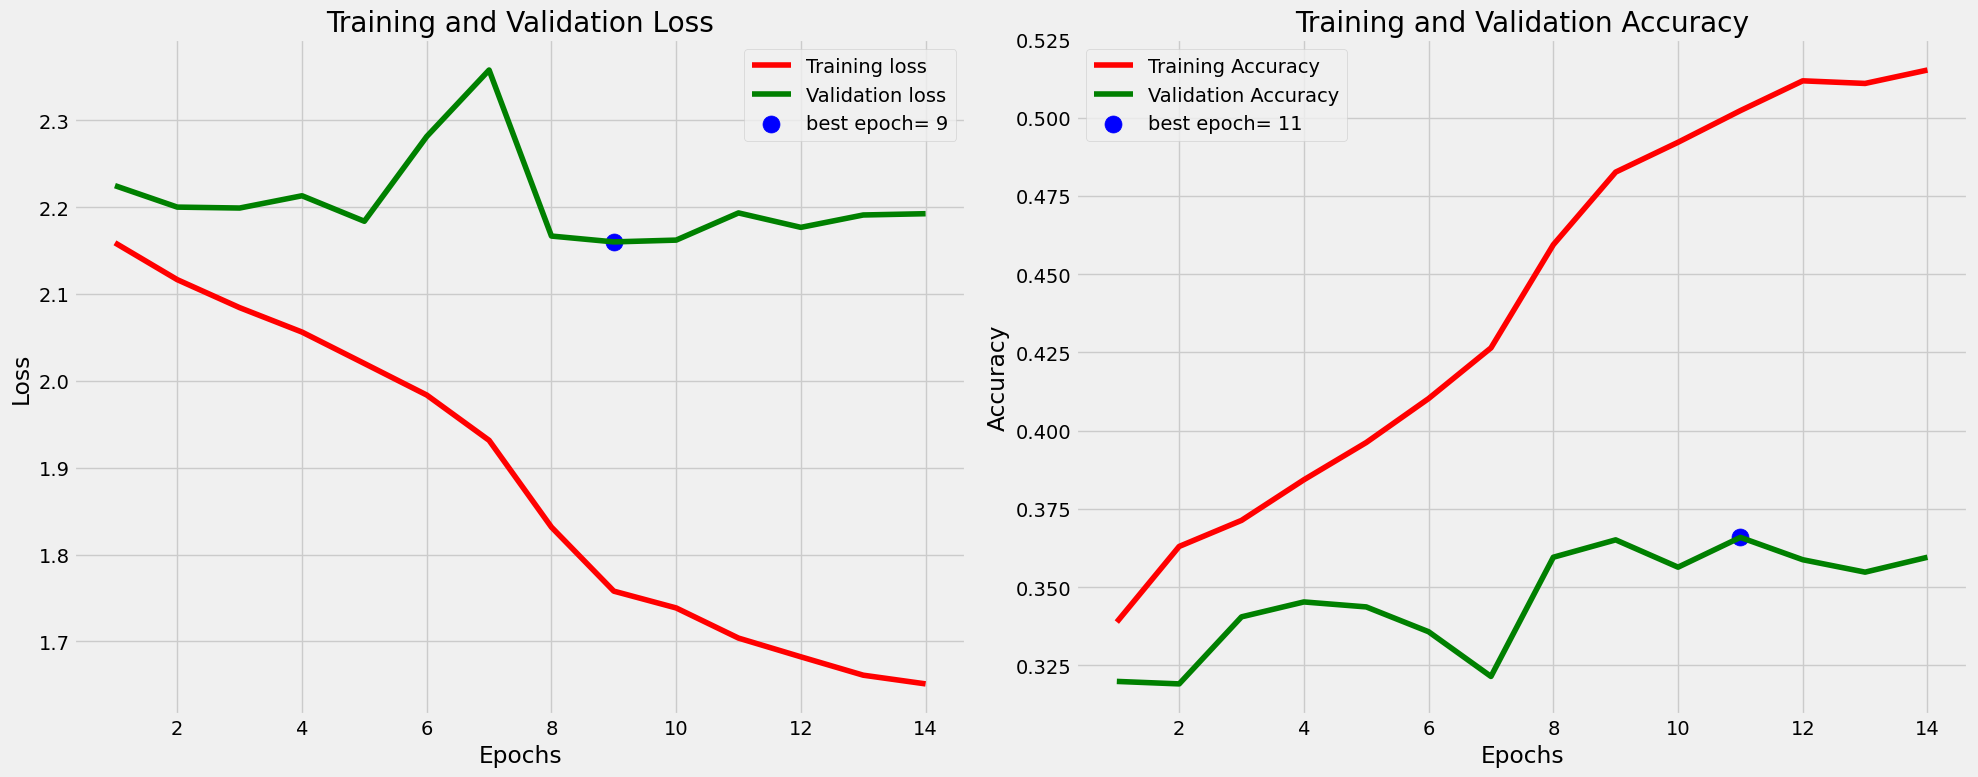

In [13]:
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

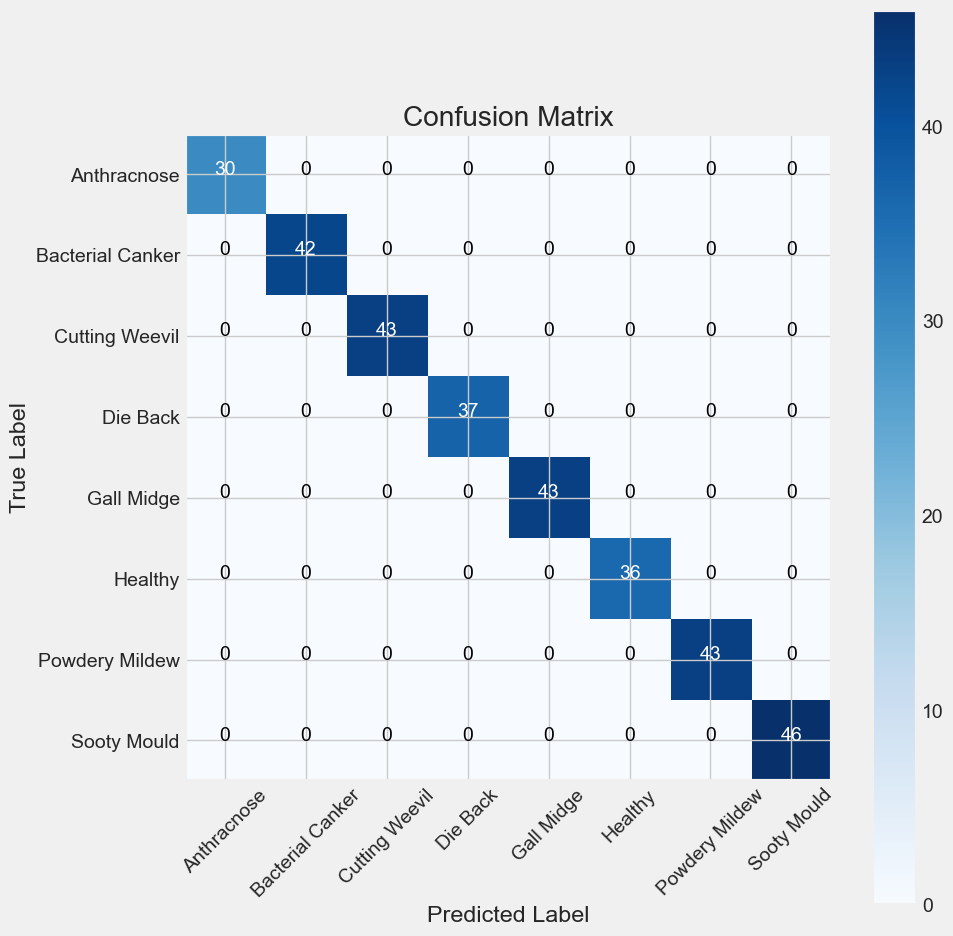

In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        30
Bacterial Canker       1.00      1.00      1.00        42
  Cutting Weevil       1.00      1.00      1.00        43
        Die Back       1.00      1.00      1.00        37
      Gall Midge       1.00      1.00      1.00        43
         Healthy       1.00      1.00      1.00        36
  Powdery Mildew       1.00      1.00      1.00        43
     Sooty Mould       1.00      1.00      1.00        46

        accuracy                           1.00       320
       macro avg       1.00      1.00      1.00       320
    weighted avg       1.00      1.00      1.00       320

